In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import datetime

from numpy.random import seed


import statsmodels.api as sm
from statsmodels import regression,stats
import statsmodels.stats.diagnostic as smd
import scipy

import math

import warnings
warnings.filterwarnings("ignore")

from sklearn import preprocessing

from keras.layers import Input, Dense,Conv1D, Conv2D, MaxPooling2D, UpSampling2D,dot,Reshape,add,Lambda
from keras.layers import BatchNormalization,LeakyReLU
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras import backend as K
import keras

from tensorflow import set_random_seed 

Using TensorFlow backend.


### define the function of getting and processing raw data 

In [2]:
def get_data(name):
    cha=pd.read_csv(''.join(('F://capstone//xz//0711//0724//autoencoder//',name,'.csv')))
    cha.date=pd.to_datetime(cha.date)
    cha.set_index('date',inplace=True,drop=True)
    return cha

### Get raw data. Each file stores its portfolio's characteristics

In [3]:
# Here are thirteen porfolios.
Rm_cha=get_data('Rm_cha')
SMB_cha=get_data('SMB_cha')
HML_cha=get_data('HML_cha')
UMD_cha=get_data('UMD_cha')
RMW_cha=get_data('RMW_cha')
CMA_cha=get_data('CMA_cha')
VOL_cha=get_data('VOL_cha')
DIV_cha=get_data('DIV_cha')
EPS_cha=get_data('EPS_cha')
ACC_cha=get_data('ACC_cha')
CAS_cha=get_data('CAS_cha')
SDE_cha=get_data('SDE_cha')
LDE_cha=get_data('LDE_cha')
REV_cha=get_data('REV_cha')

### For example, SMB_cha is the porfolio constructed by longing small market cap stocks and shorting big market cap stocks, the characteristic 'SMB' is its market capital, 'HML' is its value weighted B/M ratio

In [4]:
SMB_cha.head()

,SMB,HML,UMD,RMW,CMA,VOL,DIV,EPS,ACC,CAS,SDE,LDE,REV
date,,,,,,,,,,,,,
2002-01-02,-8.023295e+06,0.201507,-0.007754,-0.018662,0.042474,5724.964787,-0.208567,0.029950,-4084.234516,-1574.735352,-31666.357271,-24293.832395,-10162.269872
2002-01-03,-8.098141e+06,0.200724,-0.002183,-0.018784,0.042070,5554.409064,-0.212329,0.029929,-4057.971624,-1573.467536,-31483.932426,-24111.965236,-10110.574436
2002-01-04,-8.140646e+06,0.194394,-0.002329,-0.017310,0.041485,5484.945361,-0.213540,0.029525,-4057.041199,-1566.668457,-31796.722488,-24112.342570,-10095.897005
2002-01-07,-8.084675e+06,0.197844,-0.000882,-0.012883,0.041576,5121.380471,-0.095240,0.029585,-4037.724371,-1516.500206,-31377.816696,-23666.795541,-10061.890052
2002-01-08,-8.056239e+06,0.200182,-0.000851,-0.013327,0.041935,5250.372168,-0.090106,0.029133,-4048.863424,-1519.905823,-30957.048602,-23482.164649,-10064.931672


In [5]:
total_factor=pd.read_csv('F://capstone//xz//0711//0724//autoencoder//total_factor.csv')
total_factor.date=pd.to_datetime(total_factor.date)
total_factor.set_index('date',inplace=True,drop=True)
total_factor.columns=['SMB_port','HML_port','UMD_port','RMW_port','CMA_port','VOL_port',
                            'DIV_port','EPS_port','ACC_port','CAS_port','SDE_port','LDE_port','REV_port']

### This is time series returns of different portfolios

In [6]:
total_factor.head(3)

,SMB_port,HML_port,UMD_port,RMW_port,CMA_port,VOL_port,DIV_port,EPS_port,ACC_port,CAS_port,SDE_port,LDE_port,REV_port
date,,,,,,,,,,,,,
2002-01-02,0.003815,-0.005121,-0.014339,-0.014818,-0.009994,0.017023,0.004469,0.018734,0.000855,0.006003,-0.005749,-0.009336,-0.000522
2002-01-03,-0.005394,-0.006833,-0.019648,-0.032788,-0.012066,0.036267,-0.001241,0.007677,-0.014535,-0.003106,-0.026694,-0.029026,-0.010790
2002-01-04,-0.008338,0.006134,-0.011261,-0.002314,-0.006851,0.006936,0.000790,0.008373,-0.004631,-0.010519,-0.000818,0.002526,-0.002679


### get date series of training data

In [7]:
train_date=total_factor.loc[pd.Timestamp(2002,1,1):pd.Timestamp(2014,12,31),:].index

In [8]:
train_date

DatetimeIndex(['2002-01-02', '2002-01-03', '2002-01-04', '2002-01-07',
               '2002-01-08', '2002-01-09', '2002-01-10', '2002-01-11',
               '2002-01-14', '2002-01-15',
               ...
               '2014-12-17', '2014-12-18', '2014-12-19', '2014-12-22',
               '2014-12-23', '2014-12-24', '2014-12-26', '2014-12-29',
               '2014-12-30', '2014-12-31'],
              dtype='datetime64[ns]', name='date', length=3273, freq=None)

### get date series of training data

### I used dictionary to store porfolios' characteristics. The key is date. I also rescaled data.

In [9]:
total_factor.index[4:].shape

(4275,)

In [10]:
total_factor.index[:-4].shape

(4275,)

In [11]:
SMB_cha.head(3)

,SMB,HML,UMD,RMW,CMA,VOL,DIV,EPS,ACC,CAS,SDE,LDE,REV
date,,,,,,,,,,,,,
2002-01-02,-8.023295e+06,0.201507,-0.007754,-0.018662,0.042474,5724.964787,-0.208567,0.029950,-4084.234516,-1574.735352,-31666.357271,-24293.832395,-10162.269872
2002-01-03,-8.098141e+06,0.200724,-0.002183,-0.018784,0.042070,5554.409064,-0.212329,0.029929,-4057.971624,-1573.467536,-31483.932426,-24111.965236,-10110.574436
2002-01-04,-8.140646e+06,0.194394,-0.002329,-0.017310,0.041485,5484.945361,-0.213540,0.029525,-4057.041199,-1566.668457,-31796.722488,-24112.342570,-10095.897005


## I get beg_date and end_date for every five trading days

In [16]:
beg_date=[]
end_date=[]
for i in range(0,len(total_factor.index)-4,5):
    beg_date.append(total_factor.index[i])
    end_date.append(total_factor.index[i+4])
#beg_date.append(total_factor.index[i+5])
#end_date.append(total_factor.index[-1])

## I used dict to store portfolios trading data for each five trading days.

In [19]:
factor_dict={}
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(-1,1))  

for beg,end in zip(beg_date,end_date):
    factor_dict[beg]=np.vstack((SMB_cha.loc[beg:end,:].values.flatten(),
                                HML_cha.loc[beg:end,:].values.flatten(),
                                UMD_cha.loc[beg:end,:].values.flatten(),
                                RMW_cha.loc[beg:end,:].values.flatten(),
                                CMA_cha.loc[beg:end,:].values.flatten(),
                                VOL_cha.loc[beg:end,:].values.flatten(),
                                DIV_cha.loc[beg:end,:].values.flatten(),
                                EPS_cha.loc[beg:end,:].values.flatten(),
                                ACC_cha.loc[beg:end,:].values.flatten(),
                                CAS_cha.loc[beg:end,:].values.flatten(),
                                SDE_cha.loc[beg:end,:].values.flatten(), 
                                LDE_cha.loc[beg:end,:].values.flatten(),
                                REV_cha.loc[beg:end,:].values.flatten()))
    factor_dict[beg]=pd.DataFrame(factor_dict[beg])
    factor_dict[beg].index=['SMB_port','HML_port','UMD_port','RMW_port','CMA_port','VOL_port',
                            'DIV_port','EPS_port','ACC_port','CAS_port','SDE_port','LDE_port','REV_port']
    
    curr_date_list=SMB_cha.loc[beg:end,:].index
    
    for date in curr_date_list[1:]:
        factor_dict[date]=factor_dict[beg]
    
    for date in curr_date_list:
        for name in factor_dict[date].columns:
            factor_dict[date].loc[:,[name]]=min_max_scaler.fit_transform(factor_dict[date].loc[:,[name]]) 

In [23]:
#get beta and factor arrays to train
beta_train=np.array([factor_dict[train_date[0]].values])
for date in train_date[1:]:
    beta_train=np.append(beta_train,np.array([factor_dict[date].values]),axis=0)
        
fac_train=np.array([total_factor.loc[[train_date[0]],'SMB_port':].values.reshape(13)])
for date in train_date[1:]:
    fac_train=np.append(fac_train,np.array([total_factor.loc[[date],'SMB_port':].values.reshape(13)]),axis=0)

In [26]:
print('beta_train_shape: ',beta_train.shape)
print('fac_train_shape: ',fac_train.shape)

beta_train_shape:  (3273, 13, 65)
fac_train_shape:  (3273, 13)


### Below I built autoencoder model

## model1

In [36]:
seed(1) 
set_random_seed(2)
# I use four factors to do predition
encoding_dim_fac = 4  

# this is our factor encoded representations
# the input shape is (13,), meaning the returns of 13 portfolios 
input_img_fac = Input(shape=(13,))
encoded_fac = Dense(encoding_dim_fac,kernel_regularizer=regularizers.l2(0.001))(input_img_fac)
encoded_fac_model=Model(input_img_fac, encoded_fac)


# this is our beta encoded representations
# the input shape is (13,65), meaning that 13 portfolios have 65 characteristics
input_img_beta = Input(shape=(13,65))
encoded_beta= Dense(encoding_dim_fac,activation=LeakyReLU(alpha=0.01))(input_img_beta)
#='tanh')(input_img_beta)

#encoded_beta= Dense(encoding_dim_fac)(input_img_beta)
encoded_beta_model=Model(input_img_beta, encoded_beta)


# combine together
# dot the beta layers and factor layers
encoded_com= dot([encoded_fac,encoded_beta],axes=[1,2])
encoded_com_layer=Lambda(lambda x: x)(encoded_com)


# "decoded" is the lossy reconstruction of the input
#decoded = Dense(13)(encoded_com_layer)

# this model maps an input to its reconstruction
autoencoder_1 = Model(inputs=[input_img_fac,input_img_beta], outputs=encoded_com_layer)

autoencoder_1.compile(optimizer='Adam', loss='mean_squared_error',metrics=['mse'])

autoencoder_1.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 13)           0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, 13, 65)       0                                            
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 4)            56          input_7[0][0]                    
__________________________________________________________________________________________________
dense_11 (Dense)                (None, 13, 4)        264         input_8[0][0]                    
__________________________________________________________________________________________________
dot_4 (Dot

## model 2

In [28]:
seed(1) 
set_random_seed(2)
# I use four factors to do predition
encoding_dim_fac = 4  

# this is our factor encoded representations
# the input shape is (13,), meaning the returns of 13 portfolios 
input_img_fac = Input(shape=(13,))
encoded_fac = Dense(encoding_dim_fac)(input_img_fac)#,kernel_regularizer=regularizers.l2(0.01))(input_img_fac)
encoded_fac_model=Model(input_img_fac, encoded_fac)


# this is our beta encoded representations
# the input shape is (13,65), meaning that 13 portfolios have 65 characteristics
input_img_beta = Input(shape=(13,65))
encoded_beta= Dense(13)(input_img_beta)
encoded_beta= Dense(encoding_dim_fac,activation=LeakyReLU(alpha=0.01))(encoded_beta)
encoded_beta_model=Model(input_img_beta, encoded_beta)


# combine together
# dot the beta layers and factor layers
encoded_com= dot([encoded_fac,encoded_beta],axes=[1,2])
encoded_com_layer=Lambda(lambda x: x)(encoded_com)


# "decoded" is the lossy reconstruction of the input
#decoded = Dense(13)(encoded_com_layer)

# this model maps an input to its reconstruction
autoencoder_2 = Model(inputs=[input_img_fac,input_img_beta], outputs=encoded_com_layer)

autoencoder_2.compile(optimizer='Adam', loss='mean_squared_error',metrics=['mse'])
autoencoder_2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 13, 65)       0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 13)           0                                            
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 13, 13)       858         input_4[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 4)            56          input_3[0][0]                    
__________________________________________________________________________________________________
dense_5 (D

## model 3

In [29]:
seed(1) 
set_random_seed(2)
# I use four factors to do predition
encoding_dim_fac = 4  

# this is our factor encoded representations
# the input shape is (13,), meaning the returns of 13 portfolios 
input_img_fac = Input(shape=(13,))
encoded_fac = Dense(encoding_dim_fac)(input_img_fac)#,kernel_regularizer=regularizers.l2(0.01))(input_img_fac)
encoded_fac_model=Model(input_img_fac, encoded_fac)


# this is our beta encoded representations
# the input shape is (13,65), meaning that 13 portfolios have 65 characteristics
input_img_beta = Input(shape=(13,65))
encoded_beta= Dense(13)(input_img_beta)
encoded_beta= Dense(13)(encoded_beta)
encoded_beta= Dense(encoding_dim_fac,activation=LeakyReLU(alpha=0.01))(encoded_beta)
encoded_beta_model=Model(input_img_beta, encoded_beta)

# combine together
# dot the beta layers and factor layers
encoded_com= dot([encoded_fac,encoded_beta],axes=[1,2])
encoded_com_layer=Lambda(lambda x: x)(encoded_com)


# "decoded" is the lossy reconstruction of the input
#decoded = Dense(13)(encoded_com_layer)

# this model maps an input to its reconstruction
autoencoder_3 = Model(inputs=[input_img_fac,input_img_beta], outputs=encoded_com_layer)

autoencoder_3.compile(optimizer='Adam', loss='mean_squared_error',metrics=['mse'])
autoencoder_3.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 13, 65)       0                                            
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 13, 13)       858         input_6[0][0]                    
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 13)           0                                            
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 13, 13)       182         dense_7[0][0]                    
__________________________________________________________________________________________________
dense_6 (D

In [30]:
def auto_pred_stat(model): 
    #fid model
    seed(1) 
    set_random_seed(2)
    callbacks = [EarlyStopping(monitor='val_loss', patience=2)]
                 #ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]
    
    history=model.fit([fac_train,beta_train], fac_train,batch_size=500, epochs=1000,verbose=0)#,
                      #validation_split=0.2,
                      #callbacks=callbacks)
    
    # get predict returns
    return_predict=model.predict([fac_train,beta_train])
    return_predict_pd=pd.DataFrame(return_predict,columns=['SMB_port','HML_port','UMD_port','RMW_port',
                                                       'CMA_port','VOL_port','DIV_port','EPS_port',
                                                       'ACC_port','CAS_port','SDE_port','LDE_port',
                                                       'REV_port'], index=train_date)
    # calculate correlation
    corr=[]
    for name in return_predict_pd.columns:
        corr.append(pd.concat((return_predict_pd[name],total_factor[name]),axis=1).corr().iloc[0,1])
    corr=pd.DataFrame(corr,index=['SMB_port','HML_port','UMD_port','RMW_port',
                                  'CMA_port','VOL_port','DIV_port','EPS_port',
                                  'ACC_port','CAS_port','SDE_port','LDE_port',
                                  'REV_port'],columns=['auto_corr'])
    
    # calculate r_square 
    r_square=[]
    for name in return_predict_pd.columns:
        diff_square_sum=((return_predict_pd.loc[train_date,name]-total_factor.loc[train_date,name])**2).sum()
        square_sum=((total_factor.loc[train_date,name])**2).sum()
        r_square.append(1-diff_square_sum/square_sum)
        #r_square.append(diff_square_sum)
    r_square=pd.DataFrame(r_square,index=['SMB_port','HML_port','UMD_port','RMW_port',
                                                           'CMA_port','VOL_port','DIV_port','EPS_port',
                                                           'ACC_port','CAS_port','SDE_port','LDE_port',
                                                           'REV_port'],columns=['auto_r_square'])
    mse=((return_predict-fac_train)**2/(fac_train.shape[0]*fac_train.shape[1])).sum()
    return (return_predict_pd,corr,r_square,history,mse)#,return_predict) 


In [37]:
auto_return_pred_1,auto_corr_1,auto_r_square_1,history_1,mse_1=auto_pred_stat(autoencoder_1)

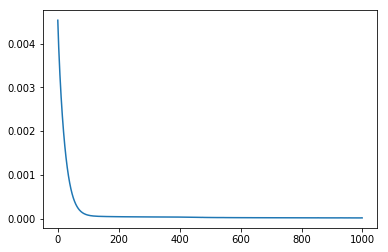

In [41]:
plt.plot(history_1.history['loss'])

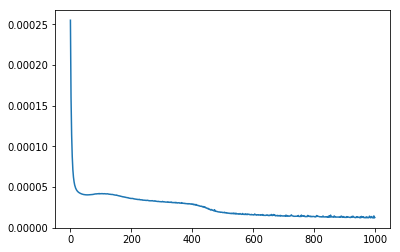

In [42]:
plt.plot(history_1.history['mean_squared_error'])

In [39]:
pd.concat((history_1.history['loss'],history_1.history['mean_squared_error']),axis=1)

TypeError: cannot concatenate object of type "<class 'list'>"; only pd.Series, pd.DataFrame, and pd.Panel (deprecated) objs are valid

In [31]:
auto_return_pred_1,auto_corr_1,auto_r_square_1,history_1,mse_1=auto_pred_stat(autoencoder_1)

auto_return_pred_2,auto_corr_2,auto_r_square_2,history_2,mse_2=auto_pred_stat(autoencoder_2)

auto_return_pred_3,auto_corr_3,auto_r_square_3,history_3,mse_3=auto_pred_stat(autoencoder_3)

Instructions for updating:
Use tf.cast instead.


In [32]:
auto_four_r_square=pd.concat((auto_r_square_1,auto_r_square_2,auto_r_square_3,F_F_r_square),axis=1)
auto_four_r_square.columns=['auto_r_square_1','auto_r_square_2','auto_r_square_3','F_F_r_square']
auto_four_r_square

NameError: name 'F_F_r_square' is not defined

In [ ]:
auto_four_loss=pd.DataFrame([history_1.history['loss'],history_2.history['loss'],history_3.history['loss']],
                           index=['history_1_loss','history_2_loss','history_3_loss']).T
auto_four_loss

In [ ]:
auto_four_r_square_mse=pd.DataFrame([[mse_1,mse_2,mse_3]],index=['mse'],columns=['mse_1','mse_2','mse_3'])
auto_four_r_square_mse

In [ ]:
auto_four_mse=pd.DataFrame([history_1.history['mean_squared_error'],history_2.history['mean_squared_error'],
                            history_3.history['mean_squared_error']],
                           index=['history_1_mse','history_2_mse','history_3_mse']).T

In [ ]:
auto_four_mse

## model 1, 5 factor
## this model has 1 dense in beta side layer and 5 factor in bottleneck layer.

In [ ]:
seed(1) 
set_random_seed(2)
# I use four factors to do predition
encoding_dim_fac = 5  

# this is our factor encoded representations
# the input shape is (13,), meaning the returns of 13 portfolios 
input_img_fac = Input(shape=(13,))
encoded_fac = Dense(encoding_dim_fac)(input_img_fac)#,kernel_regularizer=regularizers.l2(0.01))(input_img_fac)
encoded_fac_model=Model(input_img_fac, encoded_fac)


# this is our beta encoded representations
# the input shape is (13,65), meaning that 13 portfolios have 65 characteristics
input_img_beta = Input(shape=(13,65))
encoded_beta= Dense(encoding_dim_fac,activation=LeakyReLU(alpha=0.01))(input_img_beta)
encoded_beta_model=Model(input_img_beta, encoded_beta)

# combine together
# dot the beta layers and factor layers
encoded_com= dot([encoded_fac,encoded_beta],axes=[1,2])
encoded_com_layer=Lambda(lambda x: x)(encoded_com)


# "decoded" is the lossy reconstruction of the input
#decoded = Dense(13)(encoded_com_layer)

# this model maps an input to its reconstruction
autoencoder_1_5 = Model(inputs=[input_img_fac,input_img_beta], outputs=encoded_com_layer)

autoencoder_1_5.compile(optimizer='Adam', loss='mean_squared_error')

## model 1, 6 factor

In [ ]:
seed(1) 
set_random_seed(2)
# I use four factors to do predition
encoding_dim_fac = 6  

# this is our factor encoded representations
# the input shape is (13,), meaning the returns of 13 portfolios 
input_img_fac = Input(shape=(13,))
encoded_fac = Dense(encoding_dim_fac)(input_img_fac)#,kernel_regularizer=regularizers.l2(0.01))(input_img_fac)
encoded_fac_model=Model(input_img_fac, encoded_fac)


# this is our beta encoded representations
# the input shape is (13,65), meaning that 13 portfolios have 65 characteristics
input_img_beta = Input(shape=(13,65))
encoded_beta= Dense(encoding_dim_fac,activation=LeakyReLU(alpha=0.01))(input_img_beta)
encoded_beta_model=Model(input_img_beta, encoded_beta)

# combine together
# dot the beta layers and factor layers
encoded_com= dot([encoded_fac,encoded_beta],axes=[1,2])
encoded_com_layer=Lambda(lambda x: x)(encoded_com)


# "decoded" is the lossy reconstruction of the input
#decoded = Dense(13)(encoded_com_layer)

# this model maps an input to its reconstruction
autoencoder_1_6 = Model(inputs=[input_img_fac,input_img_beta], outputs=encoded_com_layer)

autoencoder_1_6.compile(optimizer='Adam', loss='mean_squared_error')

## model 1, 7 factor

In [ ]:
seed(1) 
set_random_seed(2)
# I use four factors to do predition
encoding_dim_fac = 7  

# this is our factor encoded representations
# the input shape is (13,), meaning the returns of 13 portfolios 
input_img_fac = Input(shape=(13,))
encoded_fac = Dense(encoding_dim_fac)(input_img_fac)#,kernel_regularizer=regularizers.l2(0.01))(input_img_fac)
encoded_fac_model=Model(input_img_fac, encoded_fac)


# this is our beta encoded representations
# the input shape is (13,65), meaning that 13 portfolios have 65 characteristics
input_img_beta = Input(shape=(13,65))
encoded_beta= Dense(encoding_dim_fac,activation=LeakyReLU(alpha=0.01))(input_img_beta)
encoded_beta_model=Model(input_img_beta, encoded_beta)

# combine together
# dot the beta layers and factor layers
encoded_com= dot([encoded_fac,encoded_beta],axes=[1,2])
encoded_com_layer=Lambda(lambda x: x)(encoded_com)


# "decoded" is the lossy reconstruction of the input
#decoded = Dense(13)(encoded_com_layer)

# this model maps an input to its reconstruction
autoencoder_1_7 = Model(inputs=[input_img_fac,input_img_beta], outputs=encoded_com_layer)

autoencoder_1_7.compile(optimizer='Adam', loss='mean_squared_error')

## model 1, 8 factor

In [ ]:
seed(1) 
set_random_seed(2)
# I use four factors to do predition
encoding_dim_fac = 8  

# this is our factor encoded representations
# the input shape is (13,), meaning the returns of 13 portfolios 
input_img_fac = Input(shape=(13,))
encoded_fac = Dense(encoding_dim_fac)(input_img_fac)#,kernel_regularizer=regularizers.l2(0.01))(input_img_fac)
encoded_fac_model=Model(input_img_fac, encoded_fac)


# this is our beta encoded representations
# the input shape is (13,65), meaning that 13 portfolios have 65 characteristics
input_img_beta = Input(shape=(13,65))
encoded_beta= Dense(encoding_dim_fac,activation=LeakyReLU(alpha=0.01))(input_img_beta)
encoded_beta_model=Model(input_img_beta, encoded_beta)

# combine together
# dot the beta layers and factor layers
encoded_com= dot([encoded_fac,encoded_beta],axes=[1,2])
encoded_com_layer=Lambda(lambda x: x)(encoded_com)


# "decoded" is the lossy reconstruction of the input
#decoded = Dense(13)(encoded_com_layer)

# this model maps an input to its reconstruction
autoencoder_1_8 = Model(inputs=[input_img_fac,input_img_beta], outputs=encoded_com_layer)

autoencoder_1_8.compile(optimizer='Adam', loss='mean_squared_error')

In [ ]:
auto_return_pred_1_5,auto_corr_1_5,auto_r_square_1_5,history_1_5,mse_1_5=auto_pred_stat(autoencoder_1_5)

auto_return_pred_1_6,auto_corr_1_6,auto_r_square_1_6,history_1_6,mse_1_6=auto_pred_stat(autoencoder_1_6)

auto_return_pred_1_7,auto_corr_1_7,auto_r_square_1_7,history_1_7,mse_1_7=auto_pred_stat(autoencoder_1_7)

auto_return_pred_1_8,auto_corr_1_8,auto_r_square_1_8,history_1_8,mse_1_8=auto_pred_stat(autoencoder_1_8)

In [ ]:
auto_one_four_r_square=pd.concat((auto_r_square_1,auto_r_square_1_5,auto_r_square_1_6,
                                 auto_r_square_1_7,auto_r_square_1_8),axis=1)
auto_one_four_r_square.columns=['auto_r_square_1_4','auto_r_square_1_5','auto_r_square_1_6','auto_r_square_1_7',
                                'auto_r_square_1_8']
auto_one_four_r_square

In [ ]:
auto_one_four_r_square.to_csv(r'F:\capstone\xz\0711\0724\autoencoder\outcome\auto_one_four_r_square.csv')

In [ ]:
auto_one_four_loss=pd.DataFrame([history_1.history['loss'],history_1_5.history['loss'],history_1_6.history['loss'],
                            history_1_7.history['loss'],history_1_8.history['loss'],],
                           index=['history_1_4_loss',
                                 'history_1_5_loss','history_1_6_loss','history_1_7_loss',
                                 'history_1_8_loss']).T
auto_one_four_loss.head()

In [ ]:
auto_one_four_loss.to_csv(r'F:\capstone\xz\0711\0724\autoencoder\outcome\auto_one_four_loss.csv')

In [ ]:
auto_one_four_mse=pd.DataFrame([[mse_1,mse_1_5,mse_1_6,mse_1_7,mse_1_8]],columns=['mse_1_4','mse_1_5',
                                                                                  'mse_1_6','mse_1_7','mse_1_8'],
                              index=['mse'])

In [ ]:
auto_one_four_mse.to_csv(r'F:\capstone\xz\0711\0724\autoencoder\outcome\auto_one_four_mse.csv')

## model 2, 5 factor

In [ ]:
seed(1) 
set_random_seed(2)
# I use four factors to do predition
encoding_dim_fac = 5  

# this is our factor encoded representations
# the input shape is (13,), meaning the returns of 13 portfolios 
input_img_fac = Input(shape=(13,))
encoded_fac = Dense(encoding_dim_fac)(input_img_fac)#,kernel_regularizer=regularizers.l2(0.01))(input_img_fac)
encoded_fac_model=Model(input_img_fac, encoded_fac)


# this is our beta encoded representations
# the input shape is (13,65), meaning that 13 portfolios have 65 characteristics
input_img_beta = Input(shape=(13,65))
encoded_beta= Dense(13,activation=LeakyReLU(alpha=0.01))(input_img_beta)
encoded_beta= Dense(encoding_dim_fac,activation=LeakyReLU(alpha=0.01))(encoded_beta)
encoded_beta_model=Model(input_img_beta, encoded_beta)

# combine together
# dot the beta layers and factor layers
encoded_com= dot([encoded_fac,encoded_beta],axes=[1,2])
encoded_com_layer=Lambda(lambda x: x)(encoded_com)


# "decoded" is the lossy reconstruction of the input
#decoded = Dense(13)(encoded_com_layer)

# this model maps an input to its reconstruction
autoencoder_2_5 = Model(inputs=[input_img_fac,input_img_beta], outputs=encoded_com_layer)

autoencoder_2_5.compile(optimizer='Adam', loss='mean_squared_error')

## model 2, 6 factor

In [ ]:
seed(1) 
set_random_seed(2)
# I use four factors to do predition
encoding_dim_fac = 6  

# this is our factor encoded representations
# the input shape is (13,), meaning the returns of 13 portfolios 
input_img_fac = Input(shape=(13,))
encoded_fac = Dense(encoding_dim_fac)(input_img_fac)#,kernel_regularizer=regularizers.l2(0.01))(input_img_fac)
encoded_fac_model=Model(input_img_fac, encoded_fac)


# this is our beta encoded representations
# the input shape is (13,65), meaning that 13 portfolios have 65 characteristics
input_img_beta = Input(shape=(13,65))
encoded_beta= Dense(13,activation=LeakyReLU(alpha=0.01))(input_img_beta)
encoded_beta= Dense(encoding_dim_fac,activation=LeakyReLU(alpha=0.01))(encoded_beta)
encoded_beta_model=Model(input_img_beta, encoded_beta)

# combine together
# dot the beta layers and factor layers
encoded_com= dot([encoded_fac,encoded_beta],axes=[1,2])
encoded_com_layer=Lambda(lambda x: x)(encoded_com)


# "decoded" is the lossy reconstruction of the input
#decoded = Dense(13)(encoded_com_layer)

# this model maps an input to its reconstruction
autoencoder_2_6 = Model(inputs=[input_img_fac,input_img_beta], outputs=encoded_com_layer)

autoencoder_2_6.compile(optimizer='Adam', loss='mean_squared_error')

## model 2, 7 factor

In [ ]:
seed(1) 
set_random_seed(2)
# I use four factors to do predition
encoding_dim_fac = 7  

# this is our factor encoded representations
# the input shape is (13,), meaning the returns of 13 portfolios 
input_img_fac = Input(shape=(13,))
encoded_fac = Dense(encoding_dim_fac)(input_img_fac)#,kernel_regularizer=regularizers.l2(0.01))(input_img_fac)
encoded_fac_model=Model(input_img_fac, encoded_fac)


# this is our beta encoded representations
# the input shape is (13,65), meaning that 13 portfolios have 65 characteristics
input_img_beta = Input(shape=(13,65))
encoded_beta= Dense(13,activation=LeakyReLU(alpha=0.01))(input_img_beta)
encoded_beta= Dense(encoding_dim_fac,activation=LeakyReLU(alpha=0.01))(encoded_beta)
encoded_beta_model=Model(input_img_beta, encoded_beta)

# combine together
# dot the beta layers and factor layers
encoded_com= dot([encoded_fac,encoded_beta],axes=[1,2])
encoded_com_layer=Lambda(lambda x: x)(encoded_com)


# "decoded" is the lossy reconstruction of the input
#decoded = Dense(13)(encoded_com_layer)

# this model maps an input to its reconstruction
autoencoder_2_7 = Model(inputs=[input_img_fac,input_img_beta], outputs=encoded_com_layer)

autoencoder_2_7.compile(optimizer='Adam', loss='mean_squared_error')

## model 2, 8 factor

In [ ]:
seed(1) 
set_random_seed(2)
# I use four factors to do predition
encoding_dim_fac = 8  

# this is our factor encoded representations
# the input shape is (13,), meaning the returns of 13 portfolios 
input_img_fac = Input(shape=(13,))
encoded_fac = Dense(encoding_dim_fac)(input_img_fac)#,kernel_regularizer=regularizers.l2(0.01))(input_img_fac)
encoded_fac_model=Model(input_img_fac, encoded_fac)


# this is our beta encoded representations
# the input shape is (13,65), meaning that 13 portfolios have 65 characteristics
input_img_beta = Input(shape=(13,65))
encoded_beta= Dense(13,activation=LeakyReLU(alpha=0.01))(input_img_beta)
encoded_beta= Dense(encoding_dim_fac,activation=LeakyReLU(alpha=0.01))(encoded_beta)
encoded_beta_model=Model(input_img_beta, encoded_beta)

# combine together
# dot the beta layers and factor layers
encoded_com= dot([encoded_fac,encoded_beta],axes=[1,2])
encoded_com_layer=Lambda(lambda x: x)(encoded_com)


# "decoded" is the lossy reconstruction of the input
#decoded = Dense(13)(encoded_com_layer)

# this model maps an input to its reconstruction
autoencoder_2_8 = Model(inputs=[input_img_fac,input_img_beta], outputs=encoded_com_layer)

autoencoder_2_8.compile(optimizer='Adam', loss='mean_squared_error')

In [ ]:
auto_return_pred_2_5,auto_corr_2_5,auto_r_square_2_5,history_2_5,mse_2_5=auto_pred_stat(autoencoder_2_5)

auto_return_pred_2_6,auto_corr_2_6,auto_r_square_2_6,history_2_6,mse_2_6=auto_pred_stat(autoencoder_2_6)

auto_return_pred_2_7,auto_corr_2_7,auto_r_square_2_7,history_2_7,mse_2_7=auto_pred_stat(autoencoder_2_7)

auto_return_pred_2_8,auto_corr_2_8,auto_r_square_2_8,history_2_8,mse_2_8=auto_pred_stat(autoencoder_2_8)

In [ ]:
auto_two_four_r_square=pd.concat((auto_r_square_2,auto_r_square_2_5,auto_r_square_2_6,
                                 auto_r_square_2_7,auto_r_square_2_8),axis=1)
auto_two_four_r_square.columns=['auto_r_square_2_4','auto_r_square_2_5','auto_r_square_2_6','auto_r_square_2_7',
                                'auto_r_square_2_8']
auto_two_four_r_square

In [ ]:
auto_two_four_r_square.to_csv(r'F:\capstone\xz\0711\0724\autoencoder\outcome\auto_two_four_r_square.csv')

In [ ]:
auto_two_four_loss=pd.DataFrame([history_2.history['loss'],history_2_5.history['loss'],history_2_6.history['loss'],
                            history_2_7.history['loss'],history_2_8.history['loss'],],
                           index=['history_2_4_loss',
                                 'history_2_5_loss','history_2_6_loss','history_2_7_loss',
                                 'history_2_8_loss']).T
auto_two_four_loss.head()

In [ ]:
auto_two_four_loss.to_csv(r'F:\capstone\xz\0711\0724\autoencoder\outcome\auto_two_four_loss.csv')

In [ ]:
auto_two_four_mse=pd.DataFrame([[mse_2,mse_2_5,mse_2_6,mse_2_7,mse_2_8]],columns=['mse_2_4','mse_2_5',
                                                                                  'mse_2_6','mse_2_7','mse_2_8'],
                              index=['mse'])

In [ ]:
auto_two_four_mse.to_csv(r'F:\capstone\xz\0711\0724\autoencoder\outcome\auto_two_four_mse.csv')

## model 3, 5 factor

In [ ]:
seed(1) 
set_random_seed(2)
# I use four factors to do predition
encoding_dim_fac = 5  

# this is our factor encoded representations
# the input shape is (13,), meaning the returns of 13 portfolios 
input_img_fac = Input(shape=(13,))
encoded_fac = Dense(encoding_dim_fac)(input_img_fac)#,kernel_regularizer=regularizers.l2(0.01))(input_img_fac)
encoded_fac_model=Model(input_img_fac, encoded_fac)


# this is our beta encoded representations
# the input shape is (13,65), meaning that 13 portfolios have 65 characteristics
input_img_beta = Input(shape=(13,65))
encoded_beta= Dense(13,activation=LeakyReLU(alpha=0.01))(input_img_beta)
encoded_beta= Dense(13,activation=LeakyReLU(alpha=0.01))(encoded_beta)
encoded_beta= Dense(encoding_dim_fac,activation=LeakyReLU(alpha=0.01))(encoded_beta)
encoded_beta_model=Model(input_img_beta, encoded_beta)

# combine together
# dot the beta layers and factor layers
encoded_com= dot([encoded_fac,encoded_beta],axes=[1,2])
encoded_com_layer=Lambda(lambda x: x)(encoded_com)


# "decoded" is the lossy reconstruction of the input
#decoded = Dense(13)(encoded_com_layer)

# this model maps an input to its reconstruction
autoencoder_3_5 = Model(inputs=[input_img_fac,input_img_beta], outputs=encoded_com_layer)

autoencoder_3_5.compile(optimizer='Adam', loss='mean_squared_error')

## model 3, 6 factor

In [ ]:
seed(1) 
set_random_seed(2)
# I use four factors to do predition
encoding_dim_fac = 6  

# this is our factor encoded representations
# the input shape is (13,), meaning the returns of 13 portfolios 
input_img_fac = Input(shape=(13,))
encoded_fac = Dense(encoding_dim_fac)(input_img_fac)#,kernel_regularizer=regularizers.l2(0.01))(input_img_fac)
encoded_fac_model=Model(input_img_fac, encoded_fac)


# this is our beta encoded representations
# the input shape is (13,65), meaning that 13 portfolios have 65 characteristics
input_img_beta = Input(shape=(13,65))
encoded_beta= Dense(13,activation=LeakyReLU(alpha=0.01))(input_img_beta)
encoded_beta= Dense(13,activation=LeakyReLU(alpha=0.01))(encoded_beta)
encoded_beta= Dense(encoding_dim_fac,activation=LeakyReLU(alpha=0.01))(encoded_beta)
encoded_beta_model=Model(input_img_beta, encoded_beta)

# combine together
# dot the beta layers and factor layers
encoded_com= dot([encoded_fac,encoded_beta],axes=[1,2])
encoded_com_layer=Lambda(lambda x: x)(encoded_com)


# "decoded" is the lossy reconstruction of the input
#decoded = Dense(13)(encoded_com_layer)

# this model maps an input to its reconstruction
autoencoder_3_6 = Model(inputs=[input_img_fac,input_img_beta], outputs=encoded_com_layer)

autoencoder_3_6.compile(optimizer='Adam', loss='mean_squared_error')

## model 3, 7 factor

In [ ]:
seed(1) 
set_random_seed(2)
# I use four factors to do predition
encoding_dim_fac = 7  

# this is our factor encoded representations
# the input shape is (13,), meaning the returns of 13 portfolios 
input_img_fac = Input(shape=(13,))
encoded_fac = Dense(encoding_dim_fac)(input_img_fac)#,kernel_regularizer=regularizers.l2(0.01))(input_img_fac)
encoded_fac_model=Model(input_img_fac, encoded_fac)


# this is our beta encoded representations
# the input shape is (13,65), meaning that 13 portfolios have 65 characteristics
input_img_beta = Input(shape=(13,65))
encoded_beta= Dense(13,activation=LeakyReLU(alpha=0.01))(input_img_beta)
encoded_beta= Dense(13,activation=LeakyReLU(alpha=0.01))(encoded_beta)
encoded_beta= Dense(encoding_dim_fac,activation=LeakyReLU(alpha=0.01))(encoded_beta)
encoded_beta_model=Model(input_img_beta, encoded_beta)

# combine together
# dot the beta layers and factor layers
encoded_com= dot([encoded_fac,encoded_beta],axes=[1,2])
encoded_com_layer=Lambda(lambda x: x)(encoded_com)


# "decoded" is the lossy reconstruction of the input
#decoded = Dense(13)(encoded_com_layer)

# this model maps an input to its reconstruction
autoencoder_3_7 = Model(inputs=[input_img_fac,input_img_beta], outputs=encoded_com_layer)

autoencoder_3_7.compile(optimizer='Adam', loss='mean_squared_error')

## model 3, 8 factor

In [ ]:
seed(1) 
set_random_seed(2)
# I use four factors to do predition
encoding_dim_fac = 8  

# this is our factor encoded representations
# the input shape is (13,), meaning the returns of 13 portfolios 
input_img_fac = Input(shape=(13,))
encoded_fac = Dense(encoding_dim_fac)(input_img_fac)#,kernel_regularizer=regularizers.l2(0.01))(input_img_fac)
encoded_fac_model=Model(input_img_fac, encoded_fac)


# this is our beta encoded representations
# the input shape is (13,65), meaning that 13 portfolios have 65 characteristics
input_img_beta = Input(shape=(13,65))
encoded_beta= Dense(13,activation=LeakyReLU(alpha=0.01))(input_img_beta)
encoded_beta= Dense(13,activation=LeakyReLU(alpha=0.01))(encoded_beta)
encoded_beta= Dense(encoding_dim_fac,activation=LeakyReLU(alpha=0.01))(encoded_beta)
encoded_beta_model=Model(input_img_beta, encoded_beta)

# combine together
# dot the beta layers and factor layers
encoded_com= dot([encoded_fac,encoded_beta],axes=[1,2])
encoded_com_layer=Lambda(lambda x: x)(encoded_com)


# "decoded" is the lossy reconstruction of the input
#decoded = Dense(13)(encoded_com_layer)

# this model maps an input to its reconstruction
autoencoder_3_8 = Model(inputs=[input_img_fac,input_img_beta], outputs=encoded_com_layer)

autoencoder_3_8.compile(optimizer='Adam', loss='mean_squared_error')

In [ ]:
auto_return_pred_3_5,auto_corr_3_5,auto_r_square_3_5,history_3_5,mse_3_5=auto_pred_stat(autoencoder_3_5)

auto_return_pred_3_6,auto_corr_3_6,auto_r_square_3_6,history_3_6,mse_3_6=auto_pred_stat(autoencoder_3_6)

auto_return_pred_3_7,auto_corr_3_7,auto_r_square_3_7,history_3_7,mse_3_7=auto_pred_stat(autoencoder_3_7)

auto_return_pred_3_8,auto_corr_3_8,auto_r_square_3_8,history_3_8,mse_3_8=auto_pred_stat(autoencoder_3_8)

In [ ]:
auto_three_four_r_square=pd.concat((auto_r_square_3,auto_r_square_3_5,auto_r_square_3_6,
                                 auto_r_square_3_7,auto_r_square_3_8),axis=1)
auto_three_four_r_square.columns=['auto_r_square_3_4','auto_r_square_3_5','auto_r_square_3_6','auto_r_square_3_7',
                                'auto_r_square_3_8']
auto_three_four_r_square

In [ ]:
auto_three_four_r_square.to_csv(r'F:\capstone\xz\0711\0724\autoencoder\outcome\auto_three_four_r_square.csv')

In [ ]:
auto_three_four_loss=pd.DataFrame([history_3.history['loss'],history_3_5.history['loss'],history_3_6.history['loss'],
                            history_3_7.history['loss'],history_3_8.history['loss'],],
                           index=['history_3_4_loss',
                                 'history_3_5_loss','history_3_6_loss','history_3_7_loss',
                                 'history_3_8_loss']).T
auto_three_four_loss.head()

In [ ]:
auto_three_four_loss.to_csv(r'F:\capstone\xz\0711\0724\autoencoder\outcome\auto_three_four_loss.csv')

In [ ]:
auto_three_four_mse=pd.DataFrame([[mse_3,mse_3_5,mse_3_6,mse_3_7,mse_3_8]],columns=['mse_3_5','mse_3_5',
                                                                                  'mse_3_6','mse_3_7','mse_3_8'],
                              index=['mse'])

In [ ]:
auto_three_four_mse.to_csv(r'F:\capstone\xz\0711\0724\autoencoder\outcome\auto_three_four_mse.csv')

In [ ]:
auto_three_four_loss.tail()

## Get F_F factors

In [ ]:
### get factor data

#### This is Famm and french factors, SMB has eliminated the effect of Rm_Rf, other factors except Rm_Rf have eliminated the effects of Rm_Rf and SMB.

Rm_Rf=pd.read_csv(r'F:\capstone\xz\0711\0724\Rm_Rf_F_F_decorr.csv')
Rm_Rf.date=pd.to_datetime(Rm_Rf.date)
Rm_Rf.set_index('date',drop=True,inplace=True)

SMB=pd.read_csv(r'F:\capstone\xz\0711\0724\SMB_F_F_decorr.csv')
SMB.date=pd.to_datetime(SMB.date)
SMB.set_index('date',drop=True,inplace=True)

HML=pd.read_csv(r'F:\capstone\xz\0711\0724\HML_F_F_decorr.csv')
HML.date=pd.to_datetime(HML.date)
HML.set_index('date',drop=True,inplace=True)

UMD=pd.read_csv(r'F:\capstone\xz\0711\0724\UMD_F_F_decorr.csv')
UMD.date=pd.to_datetime(UMD.date)
UMD.set_index('date',drop=True,inplace=True)

RMW=pd.read_csv(r'F:\capstone\xz\0711\0724\RMW_F_F_decorr.csv')
RMW.date=pd.to_datetime(RMW.date)
RMW.set_index('date',drop=True,inplace=True)

CMA=pd.read_csv(r'F:\capstone\xz\0711\0724\CMA_F_F_decorr.csv')
CMA.date=pd.to_datetime(CMA.date)
CMA.set_index('date',drop=True,inplace=True)

VOL=pd.read_csv(r'F:\capstone\xz\0711\0724\VOL_F_F_decorr.csv')
VOL.date=pd.to_datetime(VOL.date)
VOL.set_index('date',drop=True,inplace=True)

# HML_RMW_CMA_UMD is the average of HML,RMW,CMA,UMD
HML_RMW_CMA_UMD=pd.read_csv(r'F:\capstone\xz\0711\0724\HML_RMW_CMA_UMD_F_F_decorr.csv')
HML_RMW_CMA_UMD.date=pd.to_datetime(HML_RMW_CMA_UMD.date)
HML_RMW_CMA_UMD.set_index('date',drop=True,inplace=True)

Rf=pd.read_csv(r'F:\capstone\xz\0711\0724\Rf_F_F_decorr.csv')
Rf.date=pd.to_datetime(Rf.date)
Rf.set_index('date',drop=True,inplace=True)

total_factor_F=pd.concat((Rm_Rf,SMB,HML,UMD,RMW,CMA,VOL,HML_RMW_CMA_UMD,Rf),axis=1)

total_factor_F.head()

### Do regression by F_F factors

In [ ]:
end_mom=[3,6,9,12]*17
end_day=[31,30,30,31]*17
end_year=[2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014]*4
end_year.sort()
end_date_pre=[]
for year,mom,day in zip(end_year,end_mom,end_day):
    end_date_pre.append(pd.Timestamp(year,mom,day))
end_date_pre=end_date_pre[8:]

In [ ]:
beg_date_pre=[(date-pd.Timedelta(days=75)).replace(day=1) for date in end_date_pre ]

In [ ]:
beg_date=[]
end_date=[]
for beg,end in zip(beg_date_pre,end_date_pre):
    beg_1=total_factor_F.loc[beg:end,:].index[0]
    end_1=total_factor_F.loc[beg:end,:].index[-1]
    beg_date.append(beg_1)
    end_date.append(end_1)

In [ ]:
F_F_pred_total_pd=pd.DataFrame([])
for beg,end in zip(beg_date,end_date):
    
    X=total_factor_F.loc[beg:end,['Rm_Rf','SMB','HML','UMD']]
    X=sm.add_constant(X)
    F_F_pred_pd=pd.DataFrame([])
    for name in total_factor.columns:
        Y=total_factor.loc[beg:end,name].sub(total_factor_F.loc[beg:end,'Rf'].values,axis=0)
        model=regression.linear_model.OLS(Y,X).fit()
        Y_pred=model.predict()
        F_F_pred_pd=pd.concat((F_F_pred_pd,pd.DataFrame(Y_pred)),axis=1)
    F_F_pred_pd.columns=['SMB_port','HML_port','UMD_port','RMW_port','CMA_port','VOL_port',
                            'DIV_port','EPS_port','ACC_port','CAS_port','SDE_port','LDE_port','REV_port']
    F_F_pred_total_pd=pd.concat((F_F_pred_total_pd,F_F_pred_pd),axis=0)
F_F_pred_total_pd.index=train_date

In [ ]:
#i=0
#j=500
F_F_corr=[]
for name in F_F_pred_total_pd.columns:
    F_F_corr.append(pd.concat((F_F_pred_total_pd[name],total_factor[name]),axis=1).corr().iloc[0,1])
F_F_corr=pd.DataFrame(F_F_corr,index=['SMB_port','HML_port','UMD_port','RMW_port',
                                                       'CMA_port','VOL_port','DIV_port','EPS_port',
                                                       'ACC_port','CAS_port','SDE_port','LDE_port',
                                                       'REV_port'],columns=['F_F_corr'])

F_F_r_square=[]
for name in F_F_pred_total_pd.columns:
    diff_square_sum=((F_F_pred_total_pd.loc[train_date,name]-total_factor.loc[train_date,name])**2).sum()
    square_sum=((total_factor.loc[train_date,name])**2).sum()
    F_F_r_square.append(1-diff_square_sum/square_sum)
F_F_r_square=pd.DataFrame(F_F_r_square,index=['SMB_port','HML_port','UMD_port','RMW_port',
                                                           'CMA_port','VOL_port','DIV_port','EPS_port',
                                                           'ACC_port','CAS_port','SDE_port','LDE_port',
                                                           'REV_port'],columns=['F_F_r_square'])

In [ ]:
F_F_r_square.to_csv(r'F:\capstone\xz\0711\0724\autoencoder\outcome\F_F_r_square.csv')

In [ ]:
mse_F_F=((F_F_pred_total_pd-total_factor)**2/(F_F_pred_total_pd.shape[0]*F_F_pred_total_pd.shape[1])).sum().sum()

In [ ]:
mse_F_F_=pd.DataFrame([[mse_F_F]],columns=['mse_F_F'],index=['mse'])

In [ ]:
mse_F_F_.to_csv(r'F:\capstone\xz\0711\0724\autoencoder\outcome\mse_F_F.csv')